## Calculating likelihoods

In [1]:
import matplotlib.pyplot as plt
import corner as corner
import pandas as pd
import numpy as np
import h5py
import torch
import time
from scipy.special import logsumexp

import sys

sys.path.append('../')
from populations.bbh_models import get_models
import populations.bbh_models as read_models
from populations.utils.flow import NFlow
from populations.Flowsclass_dev import FlowModel
from populations import gw_obs

from sample import sample

PyCBC.libutils: pkg-config call failed, setting NO_PKGCONFIG=1


glasflow is using its own internal version of nflows


In [3]:
params = ['mchirp','q', 'chieff', 'z']
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
file_path='/Users/stormcolloms/Documents/PhD/Project_work/OneChannel_Flows/models_reduced.hdf5'
gw_path = '/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/gw_events'
observations, obsdata, p_theta, events = gw_obs.generate_observations(params, gw_path, \
                                            100, 'posteriors', None)

model_names, flow = read_models.get_models(file_path, ['CE'], params, use_flows=True, device='cpu')
model_names, KDE = read_models.get_models(file_path, ['CE'], params, use_flows=False, device='cpu')

100%|██████████| 20/20 [00:08<00:00,  2.36it/s]


## Likelihoods In sampling

In [4]:
#inputs: x, data, pop_models, submodels_dict, channels, use_flows
hyperparams = list(set([x.split('/', 1)[1] for x in model_names]))
Nhyper = np.max([len(x.split('/')) for x in hyperparams])
channels = sorted(list(set([x.split('/')[0] for x in model_names])))

# construct dict that relates submodels to their index number
submodels_dict = {} #dummy index dict keys:0,1,2,3, items: particular models
ctr=0 #associates with either chi_b or alpha (0 or 1)
while ctr < Nhyper:
    submodels_dict[ctr] = {}
    hyper_set = sorted(list(set([x.split('/')[ctr] for x in hyperparams])))
    for idx, model in enumerate(hyper_set): #idx associates with 0,1,2,3,(4) keys
        submodels_dict[ctr][idx] = model
    ctr += 1

In [8]:
flow_path="/Users/stormcolloms/Documents/PhD/Project_work/AMAZE_model_selection/flow_models/cosmo_weights/newmappings_2/"
for chnl in ['CE']: flow[chnl].load_model(flow_path, chnl)

In [9]:
lnlike_flow=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_flow[chibid,alphaid]=sample.lnlike([chibid,alphaid],obsdata, flow, submodels_dict, ['CE'], use_flows=True, prior_pdf=p_theta)

In [10]:
lnlike_flow

array([[-361.66952779, -407.91355282, -430.70621967, -462.0155573 ,
        -515.04192068],
       [-399.2254959 , -438.40827608, -453.45553821, -479.10365087,
        -523.16006282],
       [-462.64327648, -486.9195867 , -502.46196723, -529.19805288,
        -557.14234145],
       [-742.33668206, -779.0803143 , -823.22124562, -822.67062888,
        -778.79853546]])

Text(0.5, 1.0, 'CE channel likelihoods (flow)')

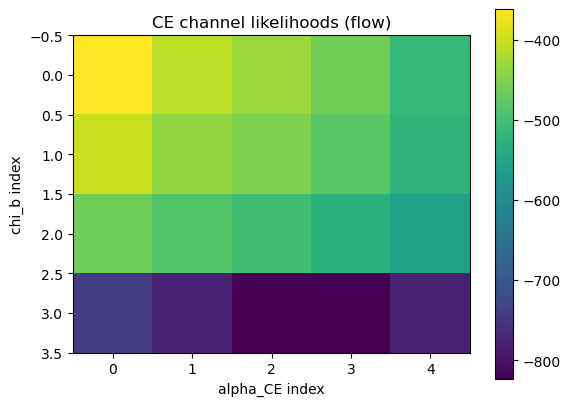

In [11]:
plt.imshow(lnlike_flow)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (flow)')

## Testing int(p(theta|alpha,chi)dtheta) =1

In [14]:
flow['CE'].flow.get_logprob(np.array([[[10.,0.9,0.1,0.1]]]), flow['CE'].map_obs(np.array([[[10.,0.9,0.1,0.1]]])), flow['CE'].mappings, np.array([[[0.,0.2]]]))

array([[-8.853371]], dtype=float32)

In [16]:
np.log(KDE['CE']['chi00']['alpha02'](np.array([[[10.,0.9,0.1,0.1]]])))

array([-9.55240501])

In [12]:
mchirps = np.linspace(0.1,37.6,20)
qs = np.linspace(0.01,0.99,20)
chieffs = np.linspace(-0.99,0.99,20)
zs = np.linspace(0.1,9.9, 20)

param_grid = np.array(np.meshgrid(mchirps,qs,chieffs,zs)).T.reshape(1,-1,4)
mapped_param_grid = flow['CE'].map_obs(param_grid)
dtheta=np.diff(mchirps)*np.diff(qs)*np.diff(chieffs)*np.diff(zs)
conds= np.reshape((np.tile(conds= np.reshape((np.tile([0.0,0.2],np.shape(param_grid)[1])),(1,-1,2)),np.shape(param_grid)[1])),(1,-1,2))
chi_b = [0.0,0.1,0.2,0.5]
alpha = [0.2,0.5,1.,2.,5.]
norm_const=np.zeros((4,5))

In [13]:
for chib_id, xb in enumerate(chi_b):
    for alpha_id, a in enumerate(alpha):
        conds= np.reshape((np.tile([xb,a],np.shape(param_grid)[1])),(1,-1,2))
        log_prob_grid=flow['CE'].flow.get_logprob(param_grid, mapped_param_grid, flow['CE'].mappings, conds)
        norm_const[chib_id,alpha_id]=np.sum((np.exp(log_prob_grid)* dtheta[0]))

KeyboardInterrupt: 

In [88]:
norm_const

array([[339.76672363, 377.84442139, 346.83984375, 408.14837646,
        352.89398193],
       [207.52415466, 350.16516113, 379.55532837, 352.20544434,
        306.01119995],
       [365.42868042, 343.50973511, 312.13253784, 367.68157959,
        274.51620483],
       [195.37277222, 233.84873962, 191.43453979, 231.06417847,
        144.09638977]])

In [18]:
from functools import reduce
import operator
def getFromDict(dataDict, mapList):
    return reduce(operator.getitem, mapList, dataDict)

In [8]:
lnlike_kde=np.zeros((4,5))
for chibid in range(4):
    for alphaid in range(5):
        lnlike_kde[chibid,alphaid]=sample.lnlike([chibid,alphaid,1.],obsdata, KDE, submodels_dict, ['CE'], use_flows=False)

['CE', 'chi00', 'alpha02']
1.0
0.0
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf]
[2.56517013e-03 9.57339440e-04 2.04189627e-03 5.97370864e-04
 1.30881890e-06 9.97676828e-04 2.25321117e-04 2.90513956e-19
 8.44569018e-06 3.70976316e-03 6.25580970e-04 1.15266243e-03
 1.79879578e-03 1.29644192e-04 1.22479564e-03 4.39814303e-04
 7.37576493e-04 1.84211706e-03 2.76904710e-02 8.21421678e-04
 1.03007113e-03 3.95796739e-04 4.18311326e-03 1.91931238e-02
 7.41726057e-04 2.96271225e-03 2.10807336e-05 1.36417313e-04
 1.75394269e-04 1.55427428e-03 3.93878213e-03 1.10706202e-03
 1.50945724e-03 3.29745043e-02 7.00538159e-04 6.03854243e-04
 1.48881486e-03 9.94733895e-08 3.84059209e-02 1.00000000e-50
 6.41952899e-04 3.34538753e-04 2.41461653e-02 1.09707441e-10
 2.07496872e-03 2.72256801e-04]
[  -5.96573047   -6.9513525

In [14]:
lnlike_kde = np.load('CE_lnlike_kde.npy')

Text(0.5, 1.0, 'CE channel likelihoods (KDEs)')

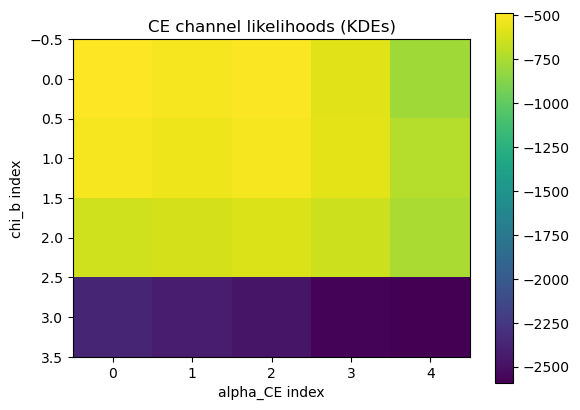

In [21]:
plt.imshow(lnlike_kde)
plt.xlabel('alpha_CE index')
plt.ylabel('chi_b index')
plt.colorbar()
plt.title('CE channel likelihoods (KDEs)')

In [15]:
lnlike_kde

array([[ -488.54896481,  -516.01045514,  -497.21744547,  -580.29421382,
         -786.29323308],
       [ -517.44113865,  -539.3906847 ,  -521.00342875,  -575.61471784,
         -720.9136174 ],
       [ -638.6766879 ,  -624.86668284,  -599.60617914,  -649.87875854,
         -752.67508215],
       [-2372.87555011, -2421.31486477, -2474.83763468, -2571.90109638,
        -2591.77152278]])